In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt

# Parameters

In [8]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = tiempo_vida_maximo- tiempo_vida_inicial           #Definicion de los pasos de integracion de algoritmo   #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-2.3))     #Tasa de mortalidad
condicion_inicial = 0.02

# Functions

In [9]:
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return (1-x)*(alpha_damage_propagation*x + disease_rate)

In [10]:
def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = condicion_inicial                                        #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

# Gillespie

In [11]:
@njit()
def Gillespie(trp0,tmax, N_total, disease_rate):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1
        else: 
            died = True
            break
        t+=τ
    return np.array([t,N, died]) 
@njit()
def Estado_celula(X0,tiempos, N_total, disease_rate):
    
    X = np.empty((len(tiempos),len(X0)))
    X[:] = np.nan
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i], N_total, disease_rate)
        if X[i][2]:
            break
    return X

# Stochastic Simulation

In [12]:
N_total_steps = [200, 250, 300, 350, 400]
disease_rate_steps = [0.001]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

alpha_damage_propagation = 0.5
for idx_D, D in enumerate(disease_rate_steps):
    for idx_N, N in enumerate(N_total_steps):
        x0 = np.array([20., int(N*condicion_inicial), False])    #Condicion Inicial
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(tiempo_vida_inicial,tiempo_vida_maximo,1.), N,D ) for i in tqdm(range(num_cel))])
        simulaciones[idx_N][idx_D] = celulas

100%|██████████| 100000/100000 [00:07<00:00, 14037.79it/s]


In [13]:
frailty_index_promedio = np.empty((len(simulaciones), len(simulaciones[0])), dtype = object)
gompertz_law_promedio = np.empty((len(simulaciones), len(simulaciones[0])), dtype = object)
for i in range(len(frailty_index_promedio)):
    for j in range(len(frailty_index_promedio[0])):
        curva_promedio_stochastic_model = np.zeros((len(simulaciones[i][j][0])))
        curva_promedio_gompertz = np.zeros((len(simulaciones[i][j][0])))
        suma = 0
        for k in tqdm(np.arange((len(simulaciones[i][j][0])))):
            curva_promedio_gompertz[k] = suma
            muertos = (np.nansum(simulaciones[i][j][:,k,2]))
            suma += muertos
            
            promedio1 = np.nanmean(simulaciones[i][j][:,k,1])/N_total_steps[i]
            curva_promedio_stochastic_model[k] = promedio1
        gompertz_law_promedio[i][j] = curva_promedio_gompertz
        frailty_index_promedio[i][j] = curva_promedio_stochastic_model

    

100%|██████████| 130/130 [00:00<00:00, 170.72it/s]


# Numerical Solution

In [68]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
alpha_damage_propagation = 0.02
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, disease_rate_steps[0])

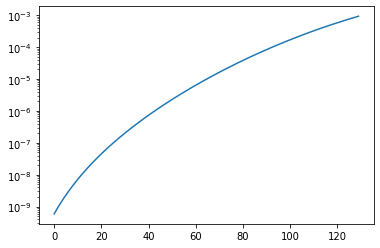

In [70]:

#plt.yscale('log')

gompertz_law_stochastic = mortality_rate*(frailty_index_promedio[4][0]**(coupling_factor/alpha_damage_propagation))

plt.plot(gompertz_law_differential_equation)

plt.yscale('log')

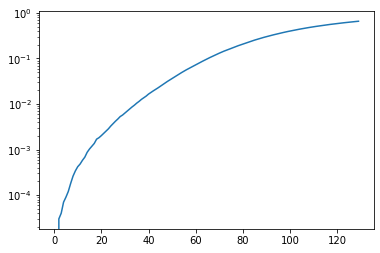

In [43]:
plt.plot(gompertz_law_promedio[4][0]/num_cel)
plt.yscale("log")

In [154]:
valores_beta_R = np.empty((2), dtype = object)
temporal_evolution = np.linspace(1,10,100000) 
data = np.e**temporal_evolution 
derivative_process = dxdt(data, temporal_evolution, kind="finite_difference", k=1)
beta_values = derivative_process/data
R_values = data/np.e**(beta_values*temporal_evolution)

valores_beta_R[0] = beta_values
valores_beta_R[1] = R_values

In [155]:
valores_beta_R[0]

array([1.000045, 1.      , 1.      , ..., 1.      , 1.      , 0.999955])

Text(0, 0.5, 'Ln($R_0$)')

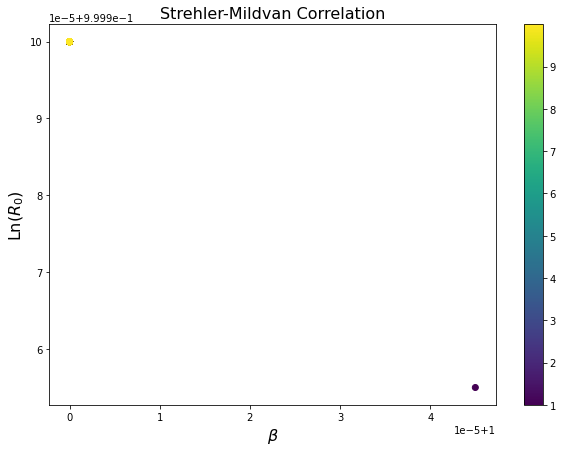

In [159]:
plt.figure(figsize=(10,7))
plt.title(r"Strehler-Mildvan Correlation", fontsize = 16)
inicial = 0
final = -1


y_values = valores_beta_R[1][inicial:final]  # Solo como ejemplo, puedes reemplazar esto con tus datos

y_min = min(y_values)
y_max = max(y_values)
y_norm = (y_values - y_min) / (y_max - y_min)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
custom_cmap = mcolors.ListedColormap(colors)

point_colors = custom_cmap(y_norm)


cmap = 'viridis'

# Paso 3: Grafica los puntos en el scatter plot con la escala continua de colores
plt.scatter(valores_beta_R[0][inicial:final], y_values, c=temporal_evolution[inicial:final], cmap=cmap)

# Puedes agregar una barra de color para visualizar la escala de colores
plt.colorbar()


#plt.scatter(valores_beta_R[0][inicial:final], valores_beta_R[1][inicial:final], label = f"#N = {N_total_steps[i]} d = {disease_rate_steps[j]}")

plt.xlabel(r"$\beta$", fontsize = 16)
plt.ylabel(r"Ln($R_0$)", fontsize = 16)
#plt.yscale("log")

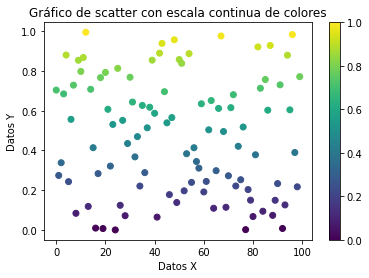

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tienes una lista de datos X e Y de longitud 100
# y_values es la lista de tus datos Y
y_values = np.random.rand(100)  # Solo como ejemplo, puedes reemplazar esto con tus datos

# Paso 1: Normaliza los datos Y
y_min = min(y_values)
y_max = max(y_values)
y_norm = (y_values - y_min) / (y_max - y_min)

# Paso 2: Utiliza una escala de colores continua (por ejemplo, viridis)
# Puedes seleccionar otra escala continua de colores si lo prefieres
cmap = 'viridis'

# Paso 3: Grafica los puntos en el scatter plot con la escala continua de colores
plt.scatter(range(100), y_values, c=y_norm, cmap=cmap)

# Agrega una barra de color para visualizar la escala de colores
plt.colorbar()

# Personaliza los ejes, etiquetas, títulos, etc., según tus necesidades
plt.xlabel('Datos X')
plt.ylabel('Datos Y')
plt.title('Gráfico de scatter con escala continua de colores')
plt.show()

# Strehler-Mildvan parameters

In [9]:
t = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,1.)
strehler_mildvan_correlation = np.empty((len(simulaciones), len(simulaciones[0])), dtype = object)

for i in range(len(frailty_index_promedio)):
    for j in range(len(frailty_index_promedio[0])):
        valores_beta_R = np.empty((2), dtype = object)
        data = gompertz_law_promedio[i][j]
        derivative_process = dxdt(data, t, kind="finite_difference", k=1)
        beta_values = derivative_process/data
        R_values = data/np.e**(beta_values*t)

        valores_beta_R[0] = beta_values
        valores_beta_R[1] = R_values

        strehler_mildvan_correlation[i][j] = valores_beta_R


/var/folders/b8/c7tcpgms33l8z7x93t10121w0000gn/T/ipykernel_44835/4093834566.py:9: RuntimeWarning: divide by zero encountered in true_divide
  beta_values = derivative_process/data
/var/folders/b8/c7tcpgms33l8z7x93t10121w0000gn/T/ipykernel_44835/4093834566.py:9: RuntimeWarning: invalid value encountered in true_divide
  beta_values = derivative_process/data


In [ ]:
data = gompertz_law_differential_equation
derivative_process_numerical_solution = dxdt(data, t, kind="finite_difference", k=1)
beta_values = derivative_process/data

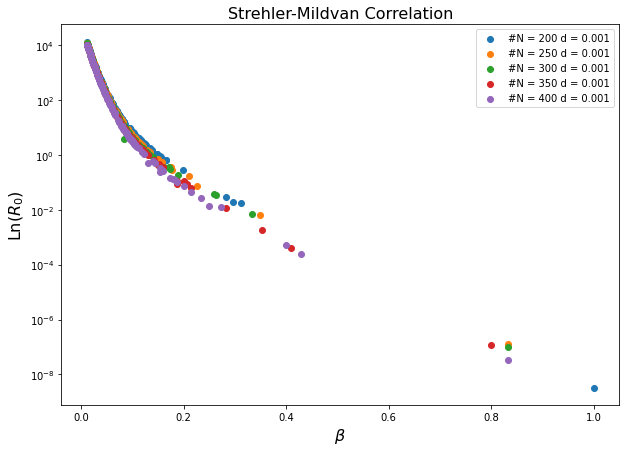

In [25]:
plt.figure(figsize=(10,7))
plt.title(r"Strehler-Mildvan Correlation", fontsize = 16)
inicial = 0
final = -1

for i in range(len(frailty_index_promedio)):
    for j in range(len(frailty_index_promedio[0])):
        plt.scatter(strehler_mildvan_correlation[i][j][0][inicial:final], strehler_mildvan_correlation[i][j][1][inicial:final], label = f"#N = {N_total_steps[i]} d = {disease_rate_steps[j]}")

plt.xlabel(r"$\beta$", fontsize = 16)
plt.ylabel(r"Ln($R_0$)", fontsize = 16)
plt.yscale("log")
plt.legend()

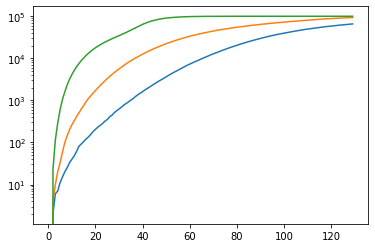

In [173]:
plt.plot(gompertz_law_promedio[0][0])
plt.plot(gompertz_law_promedio[0][1])
plt.plot(gompertz_law_promedio[0][2])
plt.yscale("log")